# CAB420 - Loading and Manipulating Large Datasets
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This example runs through some different ways to load larger datasets, such as you might use for CAB420 Assignment 2. This example does not cover all possibilities and datatypes, and will focus on image data (as that's the data that has caused the most problems over the years). The methods that we outline here will be equally applicable to other types of signal data (like audio). For text of tabular data, you're less likely to run into the sort of issues around memory use that normally causes people grief - but tips around saving pre-processed data may still be of use. In brief in this example we'll look at:
* How we can load an image dataset where the ground truth is embedded in the filename
* How we can load an image dataset where the ground truth is stored in a separate CSV file, and we need to ensure that we have correspondance between the CSV file containing the annotation and the data that we load
* How we can save a dataset that we've loaded and pre-processed using something like numpy, such that next time we can load the pre-processed version and go, rather than needing to re-run that every time.
* How we can create our own generator to work with files stored on disk
* How we can load a dataset using the tensorflow API, and then convert this to something like a numpy array (noting that for a very large dataset that you can't fit in memory, you probably don't want to do this).
* How we CAN deal with paired data, image data, where we need to apply consistent augmentation to input and output images

For datasets, we'll use small ones here to make this manageable. In particular, we'll use:
* The dataset for Q1 of Assignment 1B
* The dataset used in the Sample Assignment 1 Example
* Horses or Humans, a toy dataset in TFDS that I found amusing
* The building facades dataset, from the example `CAB420_Encoders_and_Decoders_Additional_Example_Semantic_Segmentation.ipynb`

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import glob
import pickle
import pandas
import cv2
import numpy
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

## Dataset 1: Images with Labels in the Filenames (Assignment 1B, Question 1 Data)

First up we'll look at a dataset where the labels are in the filenames. 

The data that we're using here is from Assignment 1B, Question 1, where we are performing person re-identification (ReID).

In this dataset we have:
* A training set, where we have roughly 300 people, and a bunch of images for each person.
* A gallery set and probe set, which we'll use to test the model. The gallery and probe each contain a single image for another 300 people (i.e. one image for each person in the gallery set, and one image for each person in the probe set).

To make this look a bit more like what you might be doing in Assignment 2, we'll focus on just the training set, and we'll pretend this is a classification task, i.e. you need to classify an image based on the ID of the person in the image.

**NOTE: This alternate formulation of the problem, as a classification task, is just for demonstration purposes here. DO NOT TREAT THE DATA IN THIS WAY FOR ASSIGNMENT 1B!**

### How we'll load this data

All files are named something like the following, `0001_c1s1_001051_00.jpg`, where the first 4 digits are the ID of the subject, which is our label. Given that all files are just in one directory, and all files are of the same type (i.e. they're all jpg's), we'll do the following:
* Get a list of all the jpg images in the directory of interest using `glob`
* Create two lists, `X` and `y`, for our samples and labels
* For each file:
    * Load the image, and append this to our `X` list
    * Extract the label from the filename, and append this to our `y` list
 
Let's look at some code to do this.

In [2]:
# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    # pull out the first four characters, convert to an integer
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    # this will pull out all files in base_path with the extension jpg
    files = glob.glob(os.path.join(base_path, '*.jpg'))

    # storage for data and labels
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        # load the file, because we're using opencv which is backwards with it's colour channels, we'll
        # also run this through a colour conversion. Finally, we'll divide by 255 to get the data into
        # the range [0.0 ... 1.0] rather than [0 ... 255]
        #
        # If I wanted to do other pre-processing, like resizing images, or different colour conversions
        # then I would do this here.
        #
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        # call the function we created above to get the label
        y.append(get_subject_id_from_filename(os.path.basename(f)))

    # convert the lists to numpy arrays and return
    return numpy.array(x), numpy.array(y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))

    # NOTE - removed for this demo
    # load gallery data from the test set
    # gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # NOTE - removed for this demo
    # load probe data from the test set
    # probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))

    # return the X and y data
    return train_X, train_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y, num_rows = 2, num_cols = 10):
    fig = plt.figure(figsize=[2*num_cols, 3*num_rows])
    for i in range(num_rows*num_cols):
        ax = fig.add_subplot(num_rows, num_cols, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')

We can run the above code now to load the data

(5933, 128, 64, 3)
(5933,)


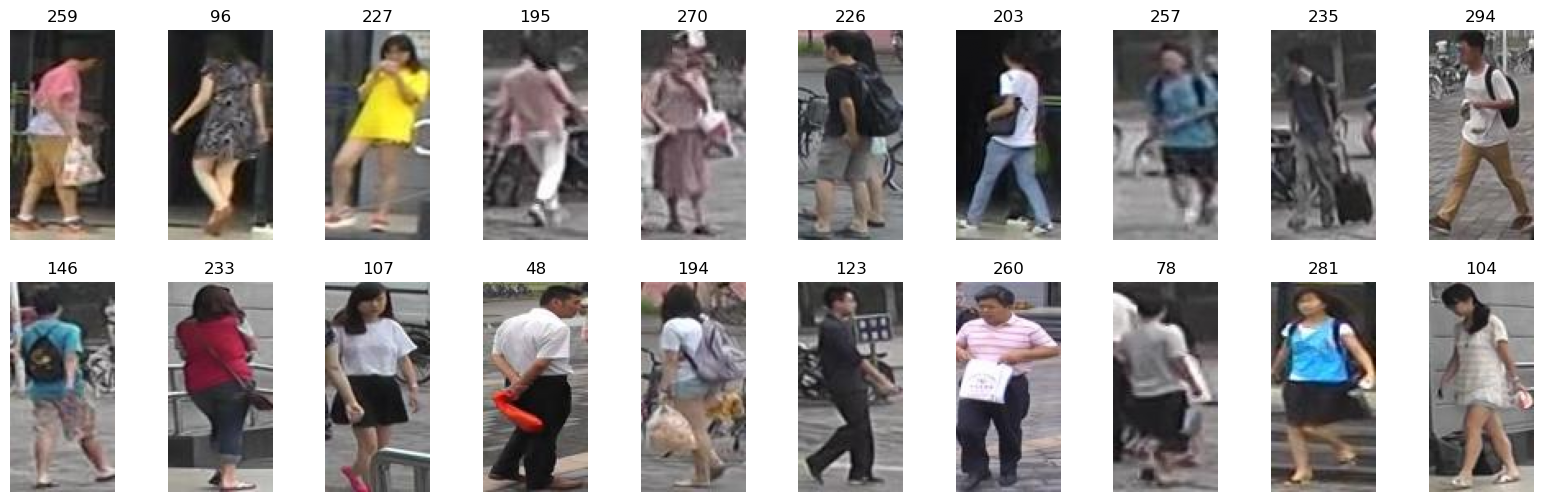

In [3]:
# note that you will probably need to change the filepath here
X, y = load_data('../data/data_loading/CAB420_Assessment_1B_Q1_Data/')

# sanity check time - print sizes and plot some images
print(X.shape)
print(y.shape)

plot_images(X, y)

### Splitting and saving the data for later

Now we'd like to split our data. Often we may have very different numbers of samples for each class, so we can use a *stratified split* to get an approximatley equal class distribution across both sets. Here, we'll split our data into train, validation and test, and then we'll save it.

This does however add one other problem we need to deal with. The stratified split will try to split samples equally across our three splits, so if we compute a 60/20/20 split, and have 5 samples for a class, we'll get 3 in the training set, and one each in the validation and testing. If we have 2 samples though, we've got a problem. To deal with this, we'll first filter our data and remove classes with fewer than five samples.

In [4]:
# find classes with too few samples
# for those of you wondering "what the fuck does this line of code do?", let's try unpack it
#  - first up, we're creating a list, that's what the [] around the outside denote. This whole things is called a list 
#    comprehension (see https://www.geeksforgeeks.org/python-list-comprehension/)
#  - we're creating this list based the y labels. Our y labels start at 1, so we've got the range(1, max(y) + 1) to go over 
#    all values from 1 upto the maximum ID in the data. We have a +1 becuase python will loop upto the integer below the one
#    that we specify, so without this we'd ignore the last class
#  - for each ID, we're going to check how many samples there are for it. To do this, we'll use the count function that
#    operates over lists. As our data is a numpy array, we'll convert it to a list to run count. Once we've got the count, 
#    (that's the y.tolist().count(i) bit) we'll test if we have too few samples. In our case we're saying too few is less 
#    than 5
#  - If the if statement evaluates to True (i.e. if we have fewer than 5 sample for that ID), then the part of the comprehension
#    before the for loop is executed, which is just appending things to our list. Here we've just got the ID, so we'll create
#    a list of all the IDs where there are fewer than 5 instances
# 
classes_to_remove = [i for i in range(1, max(y) + 1) if y.tolist().count(i) < 5]
print(classes_to_remove)

# now find all the samples that correspond to one of these classes. This will return an array of the same length as y, where
# values are either True or False. A value of True means that this sample is in our hit-list of samples to kill
samples_to_remove = numpy.isin(y, classes_to_remove)

# now, select all the elements that are flagged as False, to do this we can use the not operator, which is ~
# we'll do this for X and y
y_filtered = y[~samples_to_remove]
X_filtered = X[~samples_to_remove, :]

# now it's sanity check time. We'll check how many samples we were meant to remove, and then see how many we have left in the data
print(sum(samples_to_remove))
print(X_filtered.shape)
print(y_filtered.shape)

[20, 39, 40, 53, 59, 74, 79, 83, 84, 85, 86, 95, 98, 102, 119, 122, 125, 129, 131, 134, 140, 143, 164, 169, 170, 199, 205, 212]
94
(5839, 128, 64, 3)
(5839,)


Now that we've filtered the data, we can split it.

In [5]:
# split the data, note that we're using the stratify option here to ensure the same class distribtion across the data
train_X, rest_X, train_y, rest_y = train_test_split(X_filtered, y_filtered, train_size=0.6, random_state=4, stratify=y_filtered)
val_X, test_X, val_y, test_y = train_test_split(rest_X, rest_y, train_size=0.5, random_state=4, stratify=rest_y)

# for some sanity checking, we'll pull out a couple of classes and check the counts to see if our stratify has worked
print(train_y.tolist().count(4), val_y.tolist().count(4), test_y.tolist().count(4))
print(train_y.tolist().count(42), val_y.tolist().count(42), test_y.tolist().count(42))

12 4 4
3 1 1


Once we've split our data, we'll then save it. Saving it in this form can be a good idea for a few reasons. It means:
* If you're loading and pre-processing is slow, then you can do it once, save the results, and then just used the save version in future
* It helps ensure that you are using the same splits each time
* It allows you to easily send data to your team members, and be totally confident that they are using the same train, validation and test splits as you

I'm going to use the [`numpy.savez` function](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) which will save things in a compressed format, and I'll create a file for the train, validation and test sets. I could put everything in one, or I could split it up further into a file for train_X, a file for train_y, etc. Do whatever works for you.

**Note:** If you're original data is in a nice compressed form, like jpg images, then saving it like this will make things much bigger.
  
#### Other things you may want to do

Depending on what models you are training, you may want to:
* Reshape the data (i.e. vectorise it)
* Apply other pre-processing, like HOG
* Convert the labels to a one-hot representation

For this example I've kept it fairly simple, but for different problems these other sort of things may be totally appropriate.

In [6]:
# we can save the data very simply like this
# when we pass the data into save, we can optionally give the variables a name. The data will then be loaded as a dictionary
# and we can pull out each element by name. Without this, we'll just get some default names list 'arr_0', 'arr_1', and so on.
numpy.savez('train.npz', x = train_X, y = train_y)
numpy.savez('val.npz', x = val_X, y = val_y)
numpy.savez('test.npz', x = test_X, y = test_y)

# now to load the data
# first we load up the file
npzfile = numpy.load('train.npz')
# then pull the individual things out of the dictionary
train_X_fromfile = npzfile['x']
train_y_fromfile = npzfile['y']

# now rinse and repeat for validation and test
npzfile = numpy.load('val.npz')
val_X_fromfile = npzfile['x']
val_y_fromfile = npzfile['y']

npzfile = numpy.load('test.npz')
test_X_fromfile = npzfile['x']
test_y_fromfile = npzfile['y']

# as a sanity check, we'll make sure that our data is all the same size and shape after we've loaded it back from disk
print(train_X.shape, train_X_fromfile.shape)
print(train_y.shape, train_y_fromfile.shape)
print(val_X.shape, val_X_fromfile.shape)
print(val_y.shape, val_y_fromfile.shape)
print(test_X.shape, test_X_fromfile.shape)
print(test_y.shape, test_y_fromfile.shape)

(3503, 128, 64, 3) (3503, 128, 64, 3)
(3503,) (3503,)
(1168, 128, 64, 3) (1168, 128, 64, 3)
(1168,) (1168,)
(1168, 128, 64, 3) (1168, 128, 64, 3)
(1168,) (1168,)


## Dataset 2: Images with a separate label file (Assignment 1 Sample Problem)

For our next example we'll look at a dataset where we have a CSV file that contains the labels, and images associated with each row in the CSV. Here we want to be careful to ensure that we load images in the same order as we have in the CSV. What this means is we can just load the images, then load the CSV, and hope that everything lines up - we'll need to take a bit more care than that.

To add an extra wrinkle, we'll also set this up to load data using a generator - so we'll load the data on-demand. What this means is that our initial `load` function will load the labels and the filenames. Then we'll use a generator which will grab a batch of data, load it, and pass that somewhere. When you're dealing with very large datasets which cannot fit in memory, this is a common approach (and is what things like `tfds` do).

### Things in this data we're going to ignore

This data was originally concieved for a semantic person search challenge. What this means is you'd be given a text description, such as *a tall male wearing blue trousers, and a black and white shirt, carrying a backpack*, and then have to find them in the set of images. As such, for each image we have a heap of labels corresponding to clothing types, colours or top and bottom garments, whether they're carrying a bag, and other stuff. Furthermore, there are other images as well. In addition to the actual colour images of the people, for the training set there are semantic masks that show where in the image the different components are. We're going to ignore a lot of this data and just stick to what was used in the example assignment question - the image and the primary shirt colour.

### How we'll load the data

The CSV file that contains the annotation also contains filenames for each row. So what we'll do is just parse that CSV. We'll create single list that contains pairs of image file paths, and a list that contains the shirt colours. We'll put those two lists in a dictionary. This will be our loaded data. Then, we'll create a generator to load a batch of that at a time, on demand.

In [7]:
# load a dataset. This will load the CSV, and create a dictionary that contains the image path and ground truth
#   csv_path:      path to the csv file that contains all the meta-data, ground truth, etc
#   image_path:    path to the image of the people for whom we need to recognise traits
#
#   returns        a dictionary which contains two keys: ['images'] which contains the filepaths to the images; and ['torso_colour'], 
#                  contains the corresponding torso colours
#
# Note that there is a heap of other data not being loaded here, that includes other labels (for clothing types, leg colour, etc), as well
# as some semantic mask images.
#
def load_set(csv_path, image_path):
    
    # create storage
    # first for likley model inputs
    data = {}
    data['images'] = []
    data['torso_colour'] = []

    # load the csv file, which contains paths to images and all the ground truth data
    csv = pandas.read_csv(csv_path)
    for i, row in csv.iterrows():
        # pull out the filename. Here we'll append the path to get the full filename to load later on
        data['images'].append(os.path.join(image_path, row['filename']))
        # pull out the label
        data['torso_colour'].append(row['torcol'])
                
    return data

# load the data
#   base_path:     the path to the data, within the directory that this points to there should be the Train_Data 
#                  and Test_Data directories
#
#   returns:       loaded training and testing data
#
def load_data(base_path):
    
    train = load_set(os.path.join(base_path, 'Train_Data', 'Train.csv'), os.path.join(base_path, 'Train_Data', 'Originals'))
    test = load_set(os.path.join(base_path, 'Test_Data', 'Test.csv'), os.path.join(base_path, 'Test_Data', 'Originals'))    
    
    return train, test

In [8]:
# load the data
train, test = load_data('../data/data_loading/CAB420_Sample_Assignment_Data')

# sanity checks, we'll check
#  - the keys in the dictonary
print(train.keys())
#  - the length of both lists
print(len(train['images']), len(train['torso_colour']))
#  - and have a look at a sample element
print(train['images'][0], train['torso_colour'][0])

dict_keys(['images', 'torso_colour'])
520 520
../data/data_loading/CAB420_Sample_Assignment_Data/Train_Data/Originals/A_0001_01_001.png 3


In [9]:
# generator function. This will load batches of data on-demand
#   data:          our data. This is the dictionary loaded above
#   batch_size:    how many samples to load at a time
#   target_size:   what size images do you want? This will resize and pad, so will preserve the aspect ratio.
#   target_colour: what colour space do you want to convert to? Default is cv2.COLOR_BGR2RGB to go from
#                  opencv's default backwards world to RGB, but you may also want cv2.COLOR_BGR2GRAY 
#                  (though, don't you need to recognise colour?), or something more exotic like HSV or LAB.1
#
#   returns:       will yield a batch of X and y data
#
def ex2_generator(data, batch_size = 32, target_size = (60, 100), target_colour = cv2.COLOR_BGR2RGB):

    # create a random order for the data
    random_order = numpy.random.permutation(len(data['images']))
    # and keep track of where we're upto in the data
    current_position = 0

    # main loop
    while True:

        # storage for X and y
        X = []
        y = []

        # check if we're at the end of the data. If we don't have enough samples left in the data to grab
        # another batch, shuffle it again and reset the counter
        if (current_position + batch_size) >= len(data['images']):
            random_order = numpy.random.permutation(len(data['images']))
            current_position = 0

        # pull out a batch of data
        for i in range(batch_size):
            # Get the next image. There's a bit going on here again, so to break this down:
            #  - starting from the innermost bit, we have cv2.imread(data['images'][random_order[current_position]]), this is just 
            #    loading the next image
            #  - we're passing that image into cv2.cvtColor to convert the colour space
            #  - we've then got a / 255.0 to change the image from being [0 ... 255] to [0.0 ... 1.0]
            #  - and then we're passing the result of that into tf.image.resize_with_pad to resize the image
            X.append(tf.image.resize_with_pad(cv2.cvtColor(cv2.imread(data['images'][random_order[current_position]]), target_colour) / 255.0, 
                                              target_size[1], target_size[0]).numpy())
            # pull out the y value
            y.append(data['torso_colour'][random_order[current_position]])

            # increment our current position in the randomised order
            current_position += 1

        # return the batch, converting to numpy arrays as we go
        yield numpy.array(X), numpy.array(y)

# Load an entire dataset into numpy arrays.
#   data:          our data. This is the dictionary loaded above
#   target_size:   what size images do you want? This will resize and pad, so will preserve the aspect ratio.
#   target_colour: what colour space do you want to convert to? Default is cv2.COLOR_BGR2RGB to go from
#                  opencv's default backwards world to RGB, but you may also want cv2.COLOR_BGR2GRAY 
#                  (though, don't you need to recognise colour?), or something more exotic like HSV or LAB.1
#
#   returns:       X and y arrays, containing the loaded (and converted) input images and ground truth for all 
#                  samples
#
def load_to_numpy(data, target_size = (60, 100), target_colour = cv2.COLOR_BGR2RGB):
    X = []
    y = []

    for i in range(len(data['images'])):
        # load the image, same as above
        X.append(tf.image.resize_with_pad(cv2.cvtColor(cv2.imread(data['images'][i]), target_colour) / 255.0, 
                                          target_size[1], target_size[0]).numpy())
        # pull out the y value
        y.append(data['torso_colour'][i])

    # return the data, converting to numpy arrays as we go
    return numpy.array(X), numpy.array(y)


### Using the generator (or not)

In the cell above we have two functions. One is our generator, the second is a function to just load an entire dataset. I've got these two functions for a couple of reasons. Firstly, often, your training set will be huge and need a generator, but your testing set (and/or validation set) may not be so big. So you'll want to have the other sets just sitting in memory, while the training set uses a generator. The second resaon is far more banal, and is just to simply demonstrate different ways to work with the data.

(32, 100, 60, 3) (32,)


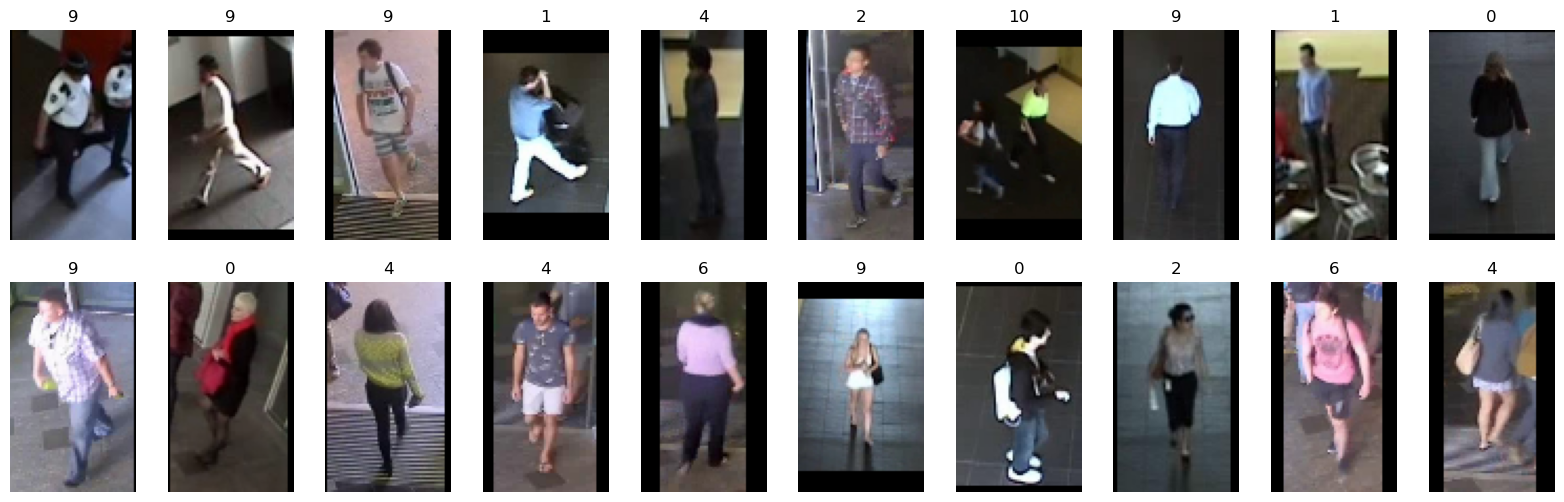

In [10]:
# create the generator
train_gen = ex2_generator(train)

# pull a batch of data
X, y = next(train_gen)
# and check that batch
print(X.shape, y.shape)
plot_images(X, y)

(32, 100, 60, 3) (32,)


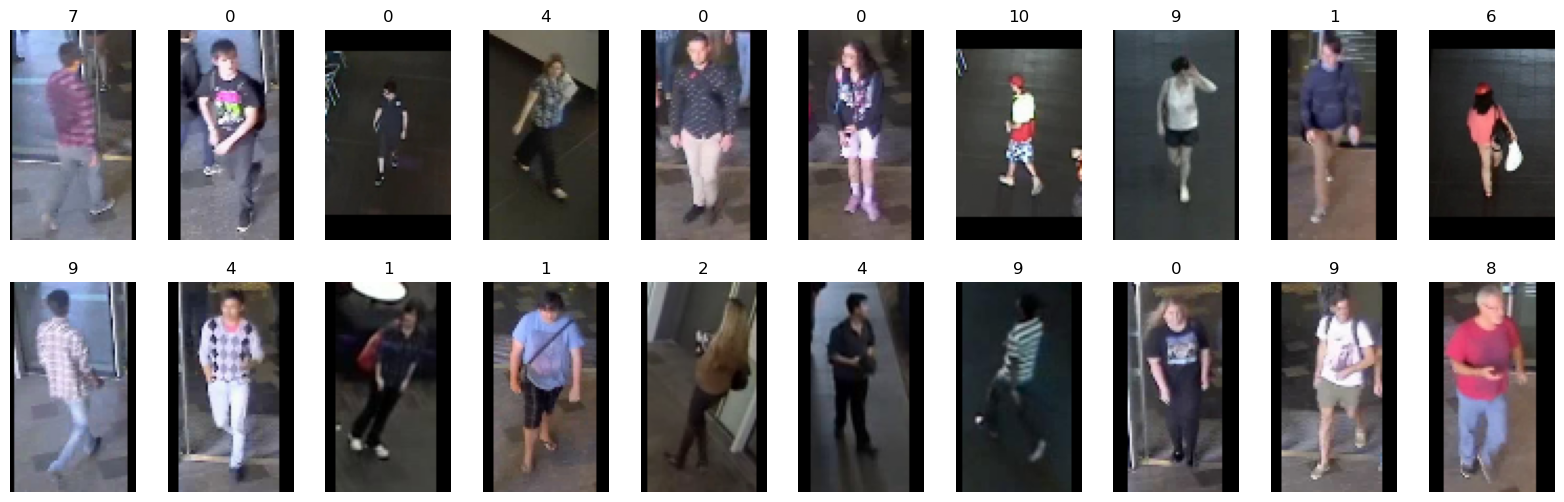

In [11]:
# because we can, pull another batch
X, y = next(train_gen)
# and check that too
print(X.shape, y.shape)
plot_images(X, y)

In [12]:
# finally, let's test loading the whole lot at once
X_test, y_test = load_to_numpy(test)
# and we can confirm that now we've got many more samples
print(X_test.shape, y_test.shape)

(196, 100, 60, 3) (196,)


### Sharing this sort of data with your fellow group members

We can't as easily package this up using numpy save as we did last time, as the assumption is that if you're using generators like we're demonstrating here then you have too much data to fit in memory, so dumping it all to one numpy array probably won't work. However, you've potentially still got training, validation and testing splits that you'd like to share. There are a lot of things you could do like create CSVs for the train, validation and testing splits, but the one I'll demonstrate is using [pickle](https://docs.python.org/3/library/pickle.html). This is not necessarily becuase it is the best, but becuase it's the one that you're perhaps least likely to know about.

Pickle will allow us dump pretty much anything to disk, and then pull it out again. This means that when you have arbitrary dictionaries or other such things, it's an easy option to work with. The idea here is you'd share the original data in whatever format that's in, and then share the training, validation and testing split definitions that you could save and load using pickle.

In [13]:
# dump data to a pickle
with open('train.pkl', 'wb') as f:
    pickle.dump(train, f)

# load data using pickle
with open('train.pkl', 'rb') as f:
    train_fromfile = pickle.load(f)

# are they the same?
print(train == train_fromfile)

True


## Dataset 3: Converting Stuff out of TFDS

There's already a couple of examples out there using TFDS (see `03_DCNNs/CAB420_DCNNs_Bonus_Example_Tensorflow_Dataset_API.ipynb`, and `05_MetricLearning/CAB420_Metric_Learning_Bonus_Example_TFDS_and_Triplet_Mining.ipynb`), but we'll have another look at a couple of things here for completeness (though really, go look at `03_DCNNs/CAB420_DCNNs_Bonus_Example_Tensorflow_Dataset_API.ipynb`).

In this example we'll play with the [*Horses or Humans*](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset, mainly because when looking through the [catalog of datasets](https://www.tensorflow.org/datasets/catalog/overview) I found this amusing, and it's small.

### How we'll load the data

Just using TFDS. The loading is really easy - but we'll then look at how we can manipulate this into different formats depending on what you want to do. In particular we'll look at:
* Getting TFDS to break this into distinct sets
* Ensuring that you get the same order of the data each time
* Converting TDFS sets into some other format (like numpy)

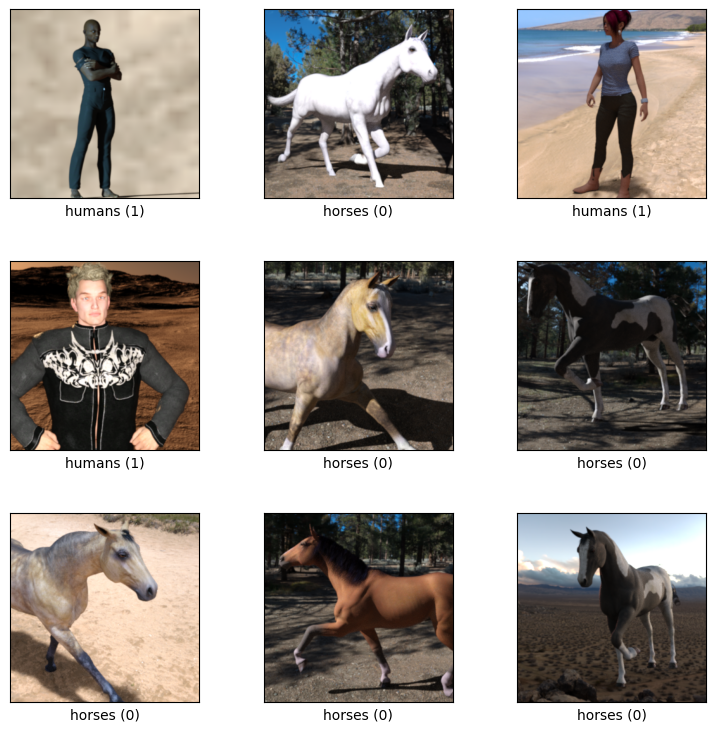

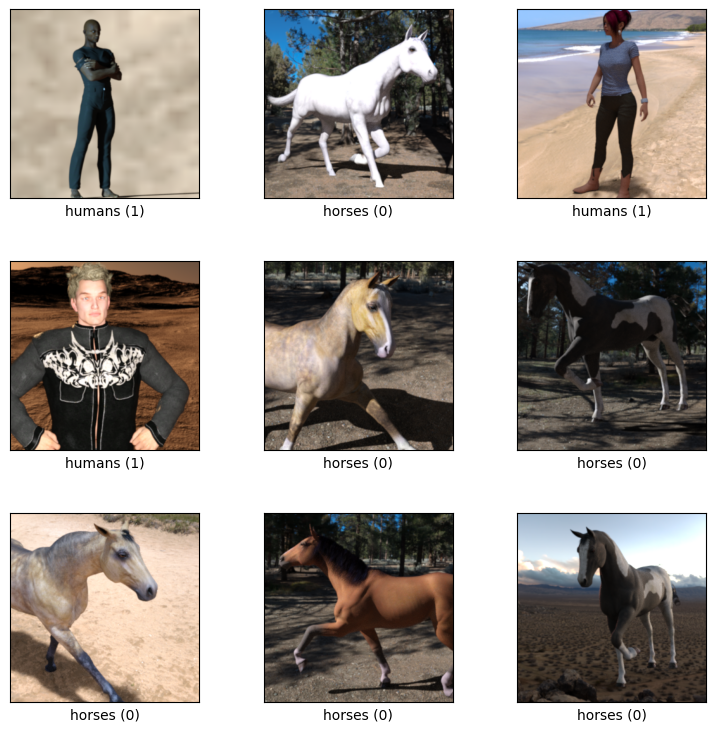

In [14]:
# set the tensorflow random seed. This will ensure that we get the same split each time
tf.random.set_seed(4)
# load the data. They key part here is the split bit. The dataset has train and test splits (this can be found in the 
# catalog linked above). We'd like three splits, so we'll partition the training set into training and validation.
(ds_train, ds_val, ds_test), ds_info = tfds.load('horses_or_humans',
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
# show some examples
tfds.show_examples(ds_train, ds_info)

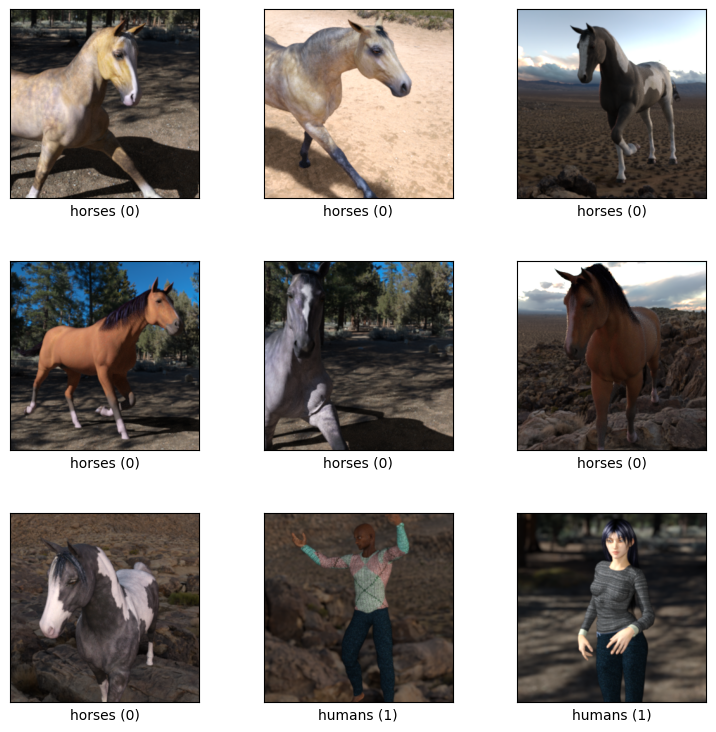

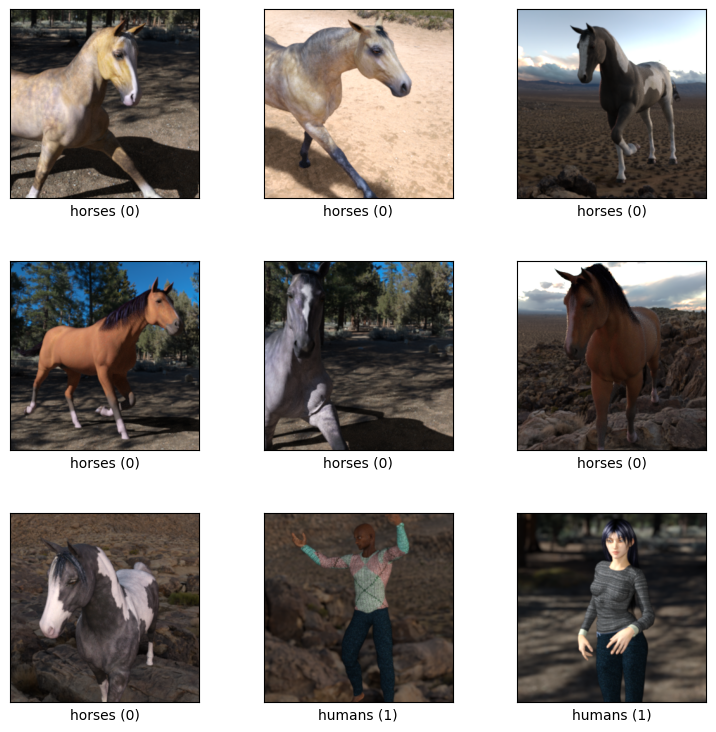

In [15]:
# Note that I could just as easily partitioned the test set into validation and test
(ds_train, ds_val, ds_test), ds_info = tfds.load('horses_or_humans',
    split=['train[:80%]', 'test[:50%]', 'test[50%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
# show some examples
tfds.show_examples(ds_train, ds_info)

At this point the data is loaded, and I can pass it straight into a DCNN to learn from. Nothing more is needed.

However, you may be wanting to compare a DCNN to an SVM - and so you'll need to convert the data. Let's look at how to do that.

In [16]:
# convert the contents of a tfds to a couple of numpy arrays
def convert_to_numpy(ds):
    
    x = []
    y = []
    # loop through the dataset
    for im,l in ds:
        # add the images and their labels to x and y lists
        #
        # if I wanted to do any other operations on the image here like resizing, colour conversion, 
        # vectorising, etc; this is where I'd do it
        #
        x.append(im)
        y.append(l)

    # convert lists to arrays
    x = numpy.array(x)
    y = numpy.array(y)
    # convert the images to a float, and scale by 1/255
    x = (x.astype(numpy.float32) / 255.0)
    
    # return the newly converted x and y
    return x, y

train_X, train_y = convert_to_numpy(ds_train)
val_X, val_y = convert_to_numpy(ds_val)
test_X, test_y = convert_to_numpy(ds_test)

print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(822, 300, 300, 3) (822,)
(128, 300, 300, 3) (128,)
(128, 300, 300, 3) (128,)


Now that I've got the data in numpy arrays, I could deal with it as we usually do. As we outlined above, this could then be saved and shared with group members to ensure a consistent evaluation approach.

Note that I'd only do this if I wanted to pass the data into something other than a deep net. For a deep learning task, I'd leave the data in the TFDS object.

## Dataset 4: Fun with Paired Data

This is really just going to repeat what's over in `CAB420_Encoders_and_Decoders_Additional_Example_Semantic_Segmentation.ipynb`, and it has some similarity to what's over in Assignment 1B Q2, but it's worth covering here as well as working with paired data where you need to apply the same augmentation to the pair is worth covering. This sort of issue could be encountered in a couple of places, including:
* When you have paired inputs. Maybe you've got colour and thermal images going in, and you need to apply the same cropping/flipping augmentation to both;
* When you have an input-output pair. This is what we've got here, we have a colour input image and a segmentation mask output image, and we want to apply the same augmentation to both.

Here, I'm going to use the facades dataset from the above mentioned example. The data is provided as a zip file, `facades.zip`. This is in the data directory, and if you unzip this file in that directory (i.e. `unzip facades.zip`) the remainder of this script should work as-is. If you wish to put the data somewhere else, change the data paths as needed.

### How we'll load the data

We'll do something not too different from above, just loop through the file names and load it up. The one wrinkle is our output data are semantic masks. We want this to be in a format where each category has it's own channel, so we've got another function below (`mask_to_categorical`) to deal with that for us. There is also one that goes the other way (`categorical_to_mask`) to help with display.

In [17]:
data_path = '../data/facades/'
num_classes = 12

def mask_to_categorical(im, num_classes):    
    one_hot_map = []
    for i in range(num_classes):
        class_map = tf.reduce_all(tf.equal(im, i+1), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)    
    return one_hot_map

def categorical_to_mask(im):
    mask = tf.dtypes.cast(tf.argmax(im, axis=2), 'float32') / 255.0
    return mask

def expand_mask_dataset(data, num_classes):
    output = []
    for i in range(data.shape[0]):
        output.append(mask_to_categorical(data[i,:], num_classes))
    return numpy.array(output)

def load_files(path, target_size, scale_factor):    
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    for filename in filenames:
        im = Image.open(filename)
        w, h = im.size
        im = im.resize((target_size, target_size))
        im=numpy.asarray(im) / scale_factor
        image_list.append(im)
    return numpy.asarray(image_list)

image_list_train = load_files(data_path + '/images/train/data/*.jpg', 128, 255.0)
mask_list_train = load_files(data_path + '/masks/train/data/*.png', 128, 1.0)
mask_list_train = numpy.reshape(mask_list_train, (numpy.shape(mask_list_train) + (1, )))
mask_list_train = expand_mask_dataset(mask_list_train, num_classes)

image_list_test = load_files(data_path + '/images/test/data/*.jpg', 128, 255.0)
mask_list_test = load_files(data_path + '/masks/test/data/*.png', 128, 1.0)
mask_list_test = numpy.reshape(mask_list_test, (numpy.shape(mask_list_test) + (1, )))
mask_list_test = expand_mask_dataset(mask_list_test, num_classes)

print(numpy.shape(image_list_train))
print(numpy.shape(mask_list_train))
print(numpy.shape(image_list_test))
print(numpy.shape(mask_list_test))

(506, 128, 128, 3)
(506, 128, 128, 12)
(100, 128, 128, 3)
(100, 128, 128, 12)


Now for the fun part. We can pack the data into a `tf.data.Dataset` like we did above just using `from_tensor_slices`. For the augmentation however, we'll create our own functions. These will use random number generation to pick a probability for the left-right flip, and the random crop, and then apply the same augmentation to both images (the input and output), ensuring that we have same thing done to both.

In [18]:
def flip_lr_augmentation(image, output, flip_lr_prob = 0.5):

    # randomly sample a value between 0 and 1
    uniform_sample = tf.random.uniform([], minval=0, maxval=1)
    # perform flip_lr with probability given by flip_lr_prob 
    flip_lr_cond = tf.math.less(uniform_sample, flip_lr_prob)
    # output is a tuple of (class, segmentation_mask), pull out the segmentation mask
    
    # wrapper fn for when we do the flip
    def flip():
        # if we are flipping, we flip both
        flipped_image = tf.image.flip_left_right(image)
        flipped_output = tf.image.flip_left_right(output)
        return flipped_image, flipped_output

    # wrapper fn for when we do NOT flip
    def no_flip():
        return image, output

    # apply augmentation    
    image, output = tf.cond(flip_lr_cond, flip, no_flip)
    # return the image, and output
    return image, output

def random_crop_augmentation(image, output, random_crop_size = (64, 64), image_size = (128, 128)):
    
    # randomly sample some cropping offsets
    x = tf.random.uniform([], minval = 0, maxval = image_size[0] - random_crop_size[0] + 1)
    y = tf.random.uniform([], minval = 0, maxval = image_size[1] - random_crop_size[1] + 1)

    # apply the same crop to both the input and the output
    cropped_image = tf.image.crop_to_bounding_box(image, int(y), int(x), int(random_crop_size[1]), int(random_crop_size[0]))
    cropped_output = tf.image.crop_to_bounding_box(output, int(y), int(x), int(random_crop_size[1]), int(random_crop_size[0]))
    
    return cropped_image, cropped_output

batch_size = 32
image_size = 64

# create data from already loaded tensors
training_data = tf.data.Dataset.from_tensor_slices((image_list_train, mask_list_train))
# apply left-right augmentation
training_data = training_data.map(lambda inp, out: flip_lr_augmentation(inp, out, 0.5), num_parallel_calls=tf.data.AUTOTUNE)
# apply random cropping
training_data = training_data.map(lambda inp, out: random_crop_augmentation(inp, out, random_crop_size = (image_size, image_size)), num_parallel_calls=tf.data.AUTOTUNE)
# get it ready to use - shuffle and set batch size
training_data = training_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Now for the plotting sanity check.

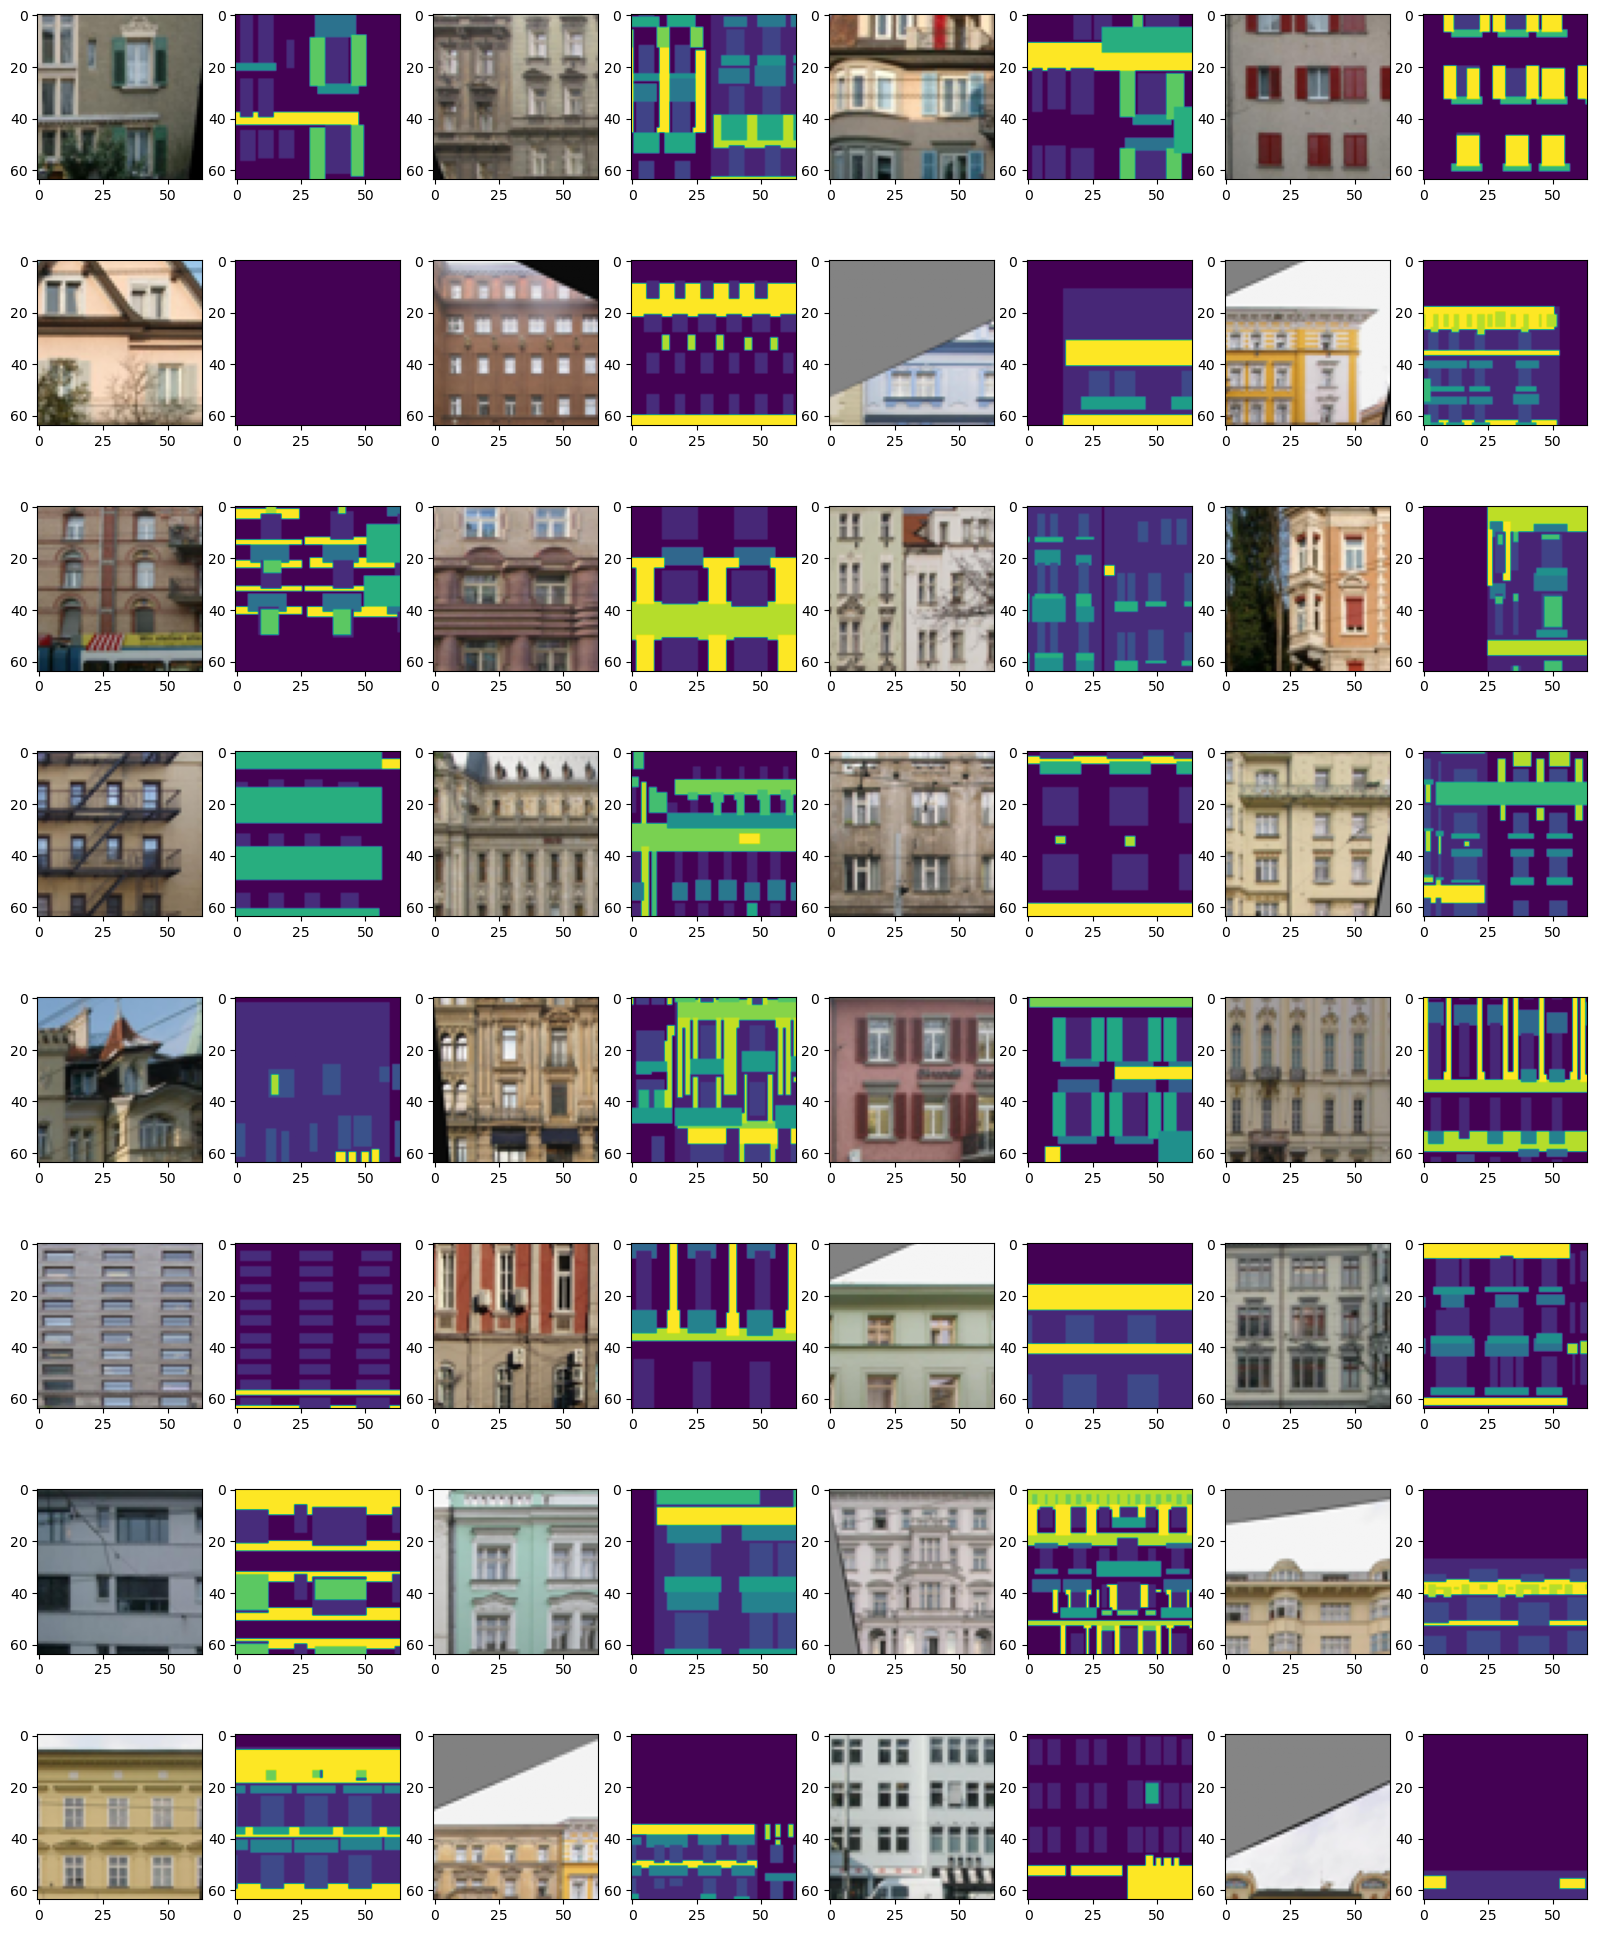

In [19]:
# training data
fig = plt.figure(figsize=[20, 25])
# sample one batch from the dataset
for image, output in training_data.take(1).as_numpy_iterator(): 
    # display image pairs
    for count in range(32):
        ax = fig.add_subplot(8, 8, count*2 + 1)
        ax.imshow(image[count, :])
        ax = fig.add_subplot(8, 8, count*2 + 2)
        ax.imshow(categorical_to_mask(output[count, :]))

We have consistent cropped images. We could simply pass this dataset into our training function and it would train on the augemented images. For validation and testing sets, there is no actual need to wrap them up in the tensorflow dataset object as they don't need augmentation applied, so the raw data arrays could just be passed in.

### Saving, Sharing, and all that stuff

In terms of saving and sharing this data, what you've save and share with group members is the data arrays after calling `load_files`. If you wanted to split data, you'd do this before saving and then save out train, validation and test splits, but you're not going to save the tensorflow object.